### Load Modules

In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

### Prepare/collect data

In [2]:
# Load and preprocess data
path = 'C:\\Desktop\\brain_tumor\\Dataset'
classes = {'no_tumor': 0, 'pituitary_tumor': 1, 'meningioma_tumor': 2, 'glioma_tumor': 3}

X, Y = [], []
for cls in classes:
    class_path = os.path.join(path, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, 0)
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize for pre-trained models
            X.append(img)
            Y.append(classes[cls])

# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Normalize and reshape data
X = X.astype('float32') / 255.0
X = X.reshape(-1, 224, 224, 1)

# Split data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
ytrain_onehot = to_categorical(ytrain, num_classes=len(classes))
ytest_onehot = to_categorical(ytest, num_classes=len(classes))

In [3]:
# Convert grayscale images to 3 channels (pre-processing step)
xtrain_rgb = np.repeat(xtrain, 3, axis=-1)  # Repeat along the last dimension to get 3 channels
xtest_rgb = np.repeat(xtest, 3, axis=-1)    # For testing data

In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load VGG16 model without the top layers (include_top=False) and freeze the layers
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers
for layer in base_vgg.layers:
    layer.trainable = False

# Build the model using Functional API
vgg_input = Input(shape=(224, 224, 3))
vgg_base_output = base_vgg(vgg_input)
flatten = Flatten()(vgg_base_output)

# Add Dense layers with L2 regularization
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(flatten)  # L2 regularization
dropout = Dropout(0.5)(dense1)
output = Dense(len(classes), activation='softmax')(dropout)

# Define the model
vgg_model = Model(inputs=vgg_input, outputs=output)

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.0001)
vgg_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks: Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train the model
history = vgg_model.fit(xtrain_rgb, ytrain_onehot, batch_size=32, epochs=15,steps_per_epoch=90,
                        validation_data=(xtest_rgb, ytest_onehot), verbose=1, callbacks=[early_stopping])

# Evaluate the model
vgg_test_accuracy = vgg_model.evaluate(xtest_rgb, ytest_onehot, verbose=0)[1]
print(f"VGG16 Accuracy: {vgg_test_accuracy:.2f}")


Epoch 1/15
79/90 ━━━━━━━━━━━━━━━━━━━━ 2:46 15s/step - accuracy: 0.4940 - loss: 3.2544

c:\Users\balavignesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


90/90 ━━━━━━━━━━━━━━━━━━━━ 1515s 17s/step - accuracy: 0.5053 - loss: 3.1881 - val_accuracy: 0.7532 - val_loss: 1.8633
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1525s 17s/step - accuracy: 0.7474 - loss: 1.6917 - val_accuracy: 0.8022 - val_loss: 1.3287
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1658s 18s/step - accuracy: 0.8081 - loss: 1.2831 - val_accuracy: 0.8354 - val_loss: 1.1209
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1665s 19s/step - accuracy: 0.8245 - loss: 1.1008 - val_accuracy: 0.8418 - val_loss: 1.0064
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1608s 18s/step - accuracy: 0.8659 - loss: 0.9596 - val_accuracy: 0.8560 - val_loss: 0.8833
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1599s 18s/step - accuracy: 0.8761 - loss: 0.8453 - val_accuracy: 0.8655 - val_loss: 0.8209
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1539s 17s/step - accuracy: 0.8822 - loss: 0.7757 - val_accuracy: 0.8782 - val_loss: 0.7659
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1526s 17s/step - accuracy: 0.8927 - loss: 0.7283 - val_accuracy: 0.871

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
# Evaluate the model

# Predict on the test set
y_pred = vgg_model.predict(xtest_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(ytest_onehot, axis=1)           # Get true class labels

print(f"Accuracy: {vgg_test_accuracy * 100:.2f}%")

precision = precision_score(y_true, y_pred_classes, average='weighted')*100 # Use 'weighted' for multiclass
recall = recall_score(y_true, y_pred_classes, average='weighted')*100
f1 = f1_score(y_true, y_pred_classes, average='weighted')*100

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 334s 17s/step
Accuracy: 90.66%
Precision: 90.97
Recall: 90.66
F1 Score: 90.70


20/20 ━━━━━━━━━━━━━━━━━━━━ 297s 15s/step


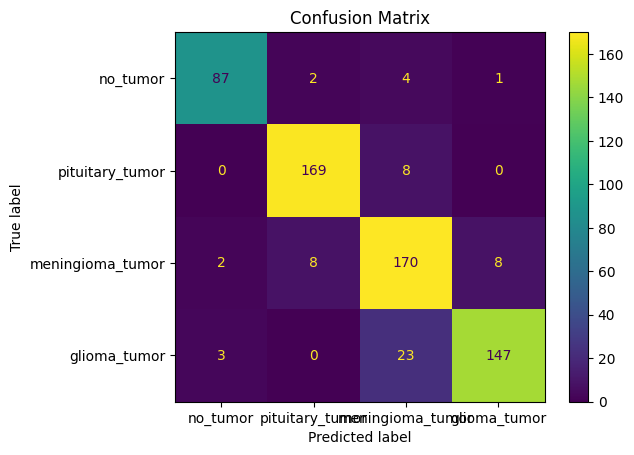

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = vgg_model.predict(xtest_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(ytest_onehot, axis=1)           # Get true class labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.keys()))
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

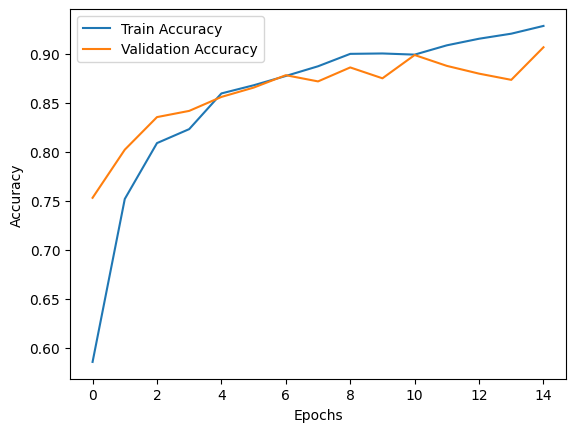

In [8]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [10]:
# Save the model for future use
vgg_model.save('tumorVGG16.h5')